In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms

import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
from sklearn.model_selection import train_test_split

In [2]:
data_dir = "/content/drive/MyDrive/dataset"

In [3]:
import shutil
from os import listdir
from os.path import isfile, join

def split_data(source, train_dir, test_dir, split_ratio=0.8):
    """
    데이터를 train과 test 폴더로 분할하는 함수.
    """
    if not os.path.exists(train_dir):
        os.makedirs(train_dir)
    if not os.path.exists(test_dir):
        os.makedirs(test_dir)

    classes = [d for d in os.listdir(source) if os.path.isdir(join(source, d))]
    for cls in classes:
        cls_source = join(source, cls)
        images = [f for f in listdir(cls_source) if isfile(join(cls_source, f))]
        train_images, test_images = train_test_split(images, train_size=split_ratio, random_state=42)

        cls_train_dir = join(train_dir, cls)
        cls_test_dir = join(test_dir, cls)
        if not os.path.exists(cls_train_dir):
            os.makedirs(cls_train_dir)
        if not os.path.exists(cls_test_dir):
            os.makedirs(cls_test_dir)

        for img in train_images:
            shutil.copy(join(cls_source, img), join(cls_train_dir, img))
        for img in test_images:
            shutil.copy(join(cls_source, img), join(cls_test_dir, img))

# 원본 데이터 경로
source_dir = data_dir

# Train과 Test 디렉토리 생성
train_dir = '/content/drive/My Drive/dataset_split/train'
test_dir = '/content/drive/My Drive/dataset_split/test'

# 데이터 분할 실행
split_data(source_dir, train_dir, test_dir, split_ratio=0.8)




In [4]:
# 하이퍼파라미터 설정
input_size = 224  # VGG16, ResNet 등 사전 학습된 모델이 기대하는 이미지 크기

# 데이터 전처리 및 증강 설정
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],  # ImageNet 평균
                             [0.229, 0.224, 0.225])  # ImageNet 표준편차
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}


In [5]:
# 데이터셋 로드
image_datasets = {x: datasets.ImageFolder(os.path.join('/content/drive/My Drive/dataset_split', x),
                                          data_transforms[x])
                  for x in ['train', 'test']}

# 데이터 로더 생성
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'test']}

# 데이터셋 크기 확인
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

# 클래스 이름 확인
class_names = image_datasets['train'].classes
print(class_names)


{'train': 90, 'test': 39}
['E_coli', 'Non_E_coli']


In [6]:
# 사전 학습된 ResNet18 모델 불러오기
model_ft = models.resnet18(pretrained=True)

# 마지막 완전 연결 층 수정 (Binary Classification을 위해 출력 노드를 1개로 설정)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)

# GPU 사용 가능 여부 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# 손실 함수 정의 (Binary Classification을 위해 BCELoss 사용)
criterion = nn.BCELoss()

# 옵티마이저 정의 (모델의 모든 파라미터를 업데이트)
optimizer_ft = optim.Adam(model_ft.parameters(), lr=1e-4)

# 학습 스케줄러 정의 (학습률 감소)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# 모델 요약 확인
print(model_ft)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 153MB/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [7]:
from PIL import Image

# 문제 이미지 경로
problem_image_path = '/content/drive/My Drive/dataset_split/train/E_coli/ecoli2.png'

try:
    img = Image.open(problem_image_path)
    img.verify()  # 이미지가 손상되지 않았는지 확인
    print(f"이미지 {problem_image_path}는 정상입니다.")
except Exception as e:
    print(f"이미지 {problem_image_path}를 여는 중 오류 발생: {e}")


이미지 /content/drive/My Drive/dataset_split/train/E_coli/ecoli2.png는 정상입니다.


In [8]:
import os
from PIL import Image

def find_and_remove_corrupted_images(directory):
    """
    주어진 디렉토리 내의 모든 이미지를 검사하고, 손상된 이미지를 제거합니다.
    """
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff')):
                file_path = os.path.join(root, file)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # 이미지가 손상되지 않았는지 확인
                except Exception as e:
                    print(f"손상된 이미지 발견: {file_path} - {e}")
                    corrupted_images.append(file_path)

    # 손상된 이미지 삭제
    for img_path in corrupted_images:
        try:
            os.remove(img_path)
            print(f"삭제된 이미지: {img_path}")
        except Exception as e:
            print(f"이미지 삭제 실패: {img_path} - {e}")

# 데이터셋 경로 설정
train_dir = '/content/drive/My Drive/dataset_split/train'
test_dir = '/content/drive/My Drive/dataset_split/test'

# 훈련 데이터에서 손상된 이미지 제거
print("훈련 데이터에서 손상된 이미지 검사 중...")
find_and_remove_corrupted_images(train_dir)

# 테스트 데이터에서 손상된 이미지 제거
print("\n테스트 데이터에서 손상된 이미지 검사 중...")
find_and_remove_corrupted_images(test_dir)


훈련 데이터에서 손상된 이미지 검사 중...

테스트 데이터에서 손상된 이미지 검사 중...


In [9]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # 기록을 저장할 리스트
    train_acc_history = []
    test_acc_history = []
    train_loss_history = []
    test_loss_history = []

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch +1, num_epochs))
        print('-' * 10)

        # 각 에포크는 훈련과 테스트 단계로 구성
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # 모델을 훈련 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터 로더에서 배치 단위로 데이터 가져오기
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device).float().unsqueeze(1)  # BCE Loss를 위해 형상 맞추기

                # 옵티마이저 초기화
                optimizer.zero_grad()

                # 순전파
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = (outputs > 0.5).float()

                    # 역전파 및 최적화 (훈련 단계에서만)
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # 기록 저장
            if phase == 'train':
                train_loss_history.append(epoch_loss)
                train_acc_history.append(epoch_acc.item())
            else:
                test_loss_history.append(epoch_loss)
                test_acc_history.append(epoch_acc.item())

                # 모델 성능이 향상되면 모델 가중치 저장
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best Test Acc: {:4f}'.format(best_acc))

    # 최상의 모델 가중치 로드
    model.load_state_dict(best_model_wts)

    # 기록 반환
    history = {
        'train_loss': train_loss_history,
        'train_acc': train_acc_history,
        'test_loss': test_loss_history,
        'test_acc': test_acc_history
    }

    return model, history

# 학습 실행 (예: 20 에포크)
model_ft, history = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                                num_epochs=20)


Epoch 1/20
----------
train Loss: 0.5974 Acc: 0.7000
test Loss: 0.3894 Acc: 0.8974

Epoch 2/20
----------
train Loss: 0.3757 Acc: 0.8444
test Loss: 0.2900 Acc: 0.8718

Epoch 3/20
----------
train Loss: 0.2671 Acc: 0.9000
test Loss: 0.2201 Acc: 0.8462

Epoch 4/20
----------
train Loss: 0.2280 Acc: 0.8889
test Loss: 0.2074 Acc: 0.8718

Epoch 5/20
----------
train Loss: 0.1419 Acc: 0.9556
test Loss: 0.2182 Acc: 0.8974

Epoch 6/20
----------
train Loss: 0.1916 Acc: 0.9222
test Loss: 0.1849 Acc: 0.9487

Epoch 7/20
----------
train Loss: 0.1131 Acc: 0.9556
test Loss: 0.1313 Acc: 0.9487

Epoch 8/20
----------
train Loss: 0.1214 Acc: 0.9556
test Loss: 0.1136 Acc: 0.9487

Epoch 9/20
----------
train Loss: 0.1109 Acc: 0.9667
test Loss: 0.1140 Acc: 0.9487

Epoch 10/20
----------
train Loss: 0.0934 Acc: 0.9778
test Loss: 0.1031 Acc: 0.9487

Epoch 11/20
----------
train Loss: 0.1087 Acc: 0.9556
test Loss: 0.1015 Acc: 0.9487

Epoch 12/20
----------
train Loss: 0.1688 Acc: 0.9222
test Loss: 0.1178 Ac

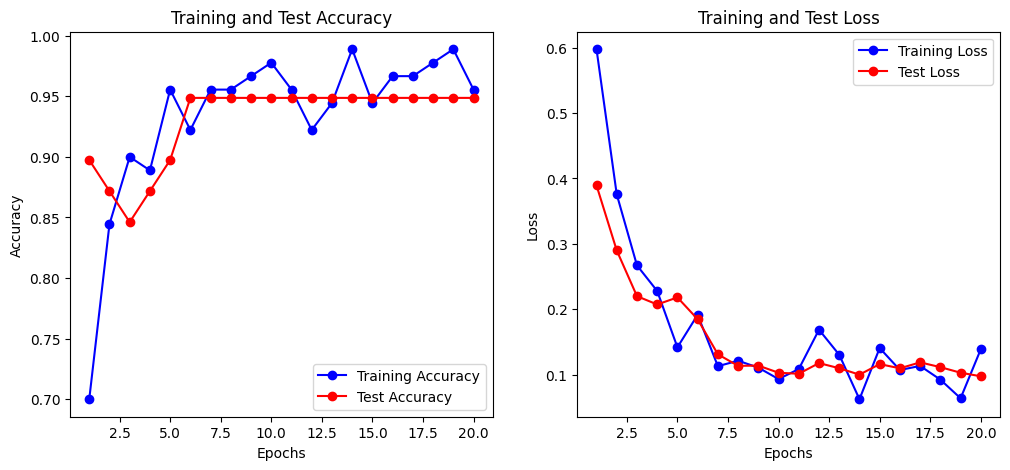

In [11]:
# 학습 결과 시각화
def plot_training_history(history):
    epochs = range(1, len(history['train_acc']) +1)

    plt.figure(figsize=(12,5))

    # 정확도 그래프
    plt.subplot(1,2,1)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, history['test_acc'], 'ro-', label='Test Accuracy')
    plt.title('Training and Test Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # 손실 그래프
    plt.subplot(1,2,2)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['test_loss'], 'ro-', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_training_history(history)


In [12]:
# 테스트 데이터셋 평가
def evaluate_model(model, dataloader, dataset_size):
    model.eval()
    running_corrects = 0
    running_loss = 0.0

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = (outputs > 0.5).float()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

    total_loss = running_loss / dataset_size
    total_acc = running_corrects.double() / dataset_size

    print('Test Loss: {:.4f} Acc: {:.4f}'.format(total_loss, total_acc))

evaluate_model(model_ft, dataloaders['test'], dataset_sizes['test'])


Test Loss: 0.1849 Acc: 0.9487


In [15]:
# 모델 저장
model_save_path = '/content/drive/My Drive/models/ecoli_classifier.pth'
torch.save(model_ft.state_dict(), model_save_path)
print('Model saved to', model_save_path)

# 모델 로드
model_loaded = models.resnet18(pretrained=True)
num_ftrs = model_loaded.fc.in_features
model_loaded.fc = nn.Sequential(
    nn.Linear(num_ftrs, 1),
    nn.Sigmoid()
)
model_loaded.load_state_dict(torch.load(model_save_path))
model_loaded = model_loaded.to(device)
print('Model loaded from', model_save_path)


Model saved to /content/drive/My Drive/models/ecoli_classifier.pth
Model loaded from /content/drive/My Drive/models/ecoli_classifier.pth


<ipython-input-15-976b538b170e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_loaded.load_state_dict(torch.load(model_save_path))


In [17]:
from PIL import Image

# 예측 함수 정의
def predict_image(model, image_path, transform, class_names):
    model.eval()
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # 배치 차원 추가
    image = image.to(device)

    with torch.no_grad():
        output = model(image)
        probability = output.item()
        prediction = 1 if probability > 0.5 else 0
        class_label = class_names[prediction]

    return probability, class_label

# 예측 예시
# Google Drive에 있는 새로운 이미지의 경로를 설정
new_image_path = "/content/drive/MyDrive/dataset/E_coli/ecoli.png"

# 변환 정의 (전처리와 동일하게 설정)
predict_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

prob, label = predict_image(model_ft, new_image_path, predict_transform, class_names)
print(f'Probability of E. coli: {prob:.4f}')
print(f'Predicted Label: {label}')


Probability of E. coli: 0.0016
Predicted Label: E_coli
